In [50]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines
from scipy.stats import kde
import matplotlib.colors as clr

In [51]:
data = '/Users/amyel/research/SMASH_project/datafiles/SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [52]:
#deredden calibration sample
u_cal = (objs["U"]-(4.239*objs["EBV"]))
g_cal = (objs["G"]-(3.303*objs["EBV"]))
i_cal = (objs["I"]-(1.263*objs["EBV"]))
r_cal = (objs["R"]-(2.285*objs["EBV"]))
feh_cal = objs["FEH"]
u_g_cal = u_cal - g_cal
g_r_cal = g_cal - r_cal

In [53]:
ret = {}
xedge = {}
yedge = {}
bin = {}

In [54]:
ret['original'],xedge['original'],yedge['original'],bin['original'] = stats.binned_statistic_2d((u_g_cal),(g_r_cal),feh_cal,'median',50)


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [55]:
metal = {}
std = {}
error = {}
initial_stars = []
cut_stars = []
for i, method in enumerate (('original','median','mean','uerr')):
    metal[method] = []
    std[method] = []
    error[method] = []


In [56]:
fields= [1,   2,   3,   4,   5,   7,   8,   9,  12,  13,  14,  15,  16,
        18,  19,  20,  21,  22,  24,  26,  27,  28,  29,  31,  32,  33,
        34,  37,  40,  44,  46,  49,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  63,  64,  66,  68, 149, 150, 156, 176, 177,
       178]

In [57]:
fx = fitsio.FITS('/Users/amyel/research/SMASH_project/datafiles/SMASH_fields/vsix/starsthree/Field55_allobj_deep_stars.fits.gz')
objs_new = fx[1].read()

In [58]:
#deredden the colors from input file
u = (objs_new["U"]-(4.239*objs_new["EBV"]))
g = (objs_new["G"]-(3.303*objs_new["EBV"]))
i = (objs_new["I"]-(1.263*objs_new["EBV"]))
r = (objs_new["R"]-(2.285*objs_new["EBV"]))

#make cuts
selected = np.where(((g-i)>=0.11)&((g-i)<=0.44)&(g>=21.9)&(g<=22.8)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
u = u[selected]
g = g[selected]
i = i[selected]
r = r[selected]
u_g = u-g
g_r = g-r

In [59]:
median_u_g = np.median(u_g)
median_g_r = np.median(g_r)

In [60]:
ix = np.searchsorted(xedge['original'],median_u_g)
ix = ix-1 
iy = np.searchsorted(yedge['original'],median_g_r)
iy = iy-1
    
feh = ret['original'][ix,iy]

In [61]:
ix = np.searchsorted(xedge['original'],median_u_g)
iy = np.searchsorted(yedge['original'],median_g_r)


In [62]:
feh

-1.572399616241455

In [63]:
feh = ret['original'][ix,iy]

In [64]:
feh

-1.3767668008804321

In [65]:

#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    selected = np.where(((g-i)>=0.11)&((g-i)<=0.44)&(g>=21.9)&(g<=22.8)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    
    uerr = objs_new['UERR'][selected]
    wt_uerr = 1/(uerr**2)

    
    #original metallicity values from binned_statistic_sd from original calibration sample 
    ind, = np.where(((u_g)>=xedge['original'].min())&((u_g)<=xedge['original'].max())&((g_r)>=yedge['original'].min())&((g_r)<=yedge['original'].max()))
    ix = np.searchsorted(xedge['original'],(u_g)[ind])
    ix = ix - 1
    iy = np.searchsorted(yedge['original'],(g_r)[ind])
    iy = iy - 1
    feh = ret['original'][ix,iy]
    N = np.count_nonzero(~np.isnan(feh))
    #mean_metallicity['original'].append(np.nanmean(feh))
    print("metallicity for original method:",(np.nanmedian(feh)))
    metal['original'].append(np.nanmedian(feh))
    std['original'].append(np.nanstd(feh))
    error['original'].append((np.nanstd(feh))/np.sqrt(N))
    
    
    mean_u_g = np.mean(u_g)
    mean_g_r = np.mean(g_r)
    median_u_g = np.median(u_g)
    median_g_r = np.median(g_r)
    
    weight_u_g = (np.sum(wt_uerr*u_g))/(np.sum(wt_uerr))
    weight_g_r = (np.sum(wt_uerr*g_r))/(np.sum(wt_uerr))
    
    ix = np.searchsorted(xedge['original'],mean_u_g)
    ix = ix-1 
    iy = np.searchsorted(yedge['original'],mean_g_r)
    iy = iy-1
    
    feh = ret['original'][ix,iy]
    print("metallicity for mean color method:",feh)
    metal['mean'].append(feh)

    ix = np.searchsorted(xedge['original'],median_u_g)
    ix = ix-1 
    iy = np.searchsorted(yedge['original'],median_g_r)
    iy = iy-1
    
    feh = ret['original'][ix,iy]
    print("metallicity for median color method:",feh)
    metal['median'].append(feh)
    
    ix = np.searchsorted(xedge['original'],weight_u_g)
    ix = ix-1 
    iy = np.searchsorted(yedge['original'],weight_g_r)
    iy = iy-1
    
    feh = ret['original'][ix,iy]
    print("metallicity for uerr color method:",feh)
    metal['uerr'].append(feh)    
    
    
    

    return 0


In [66]:

if __name__=="__main__":
    for number in fields:
        metallicity('/Users/amyel/research/SMASH_project/datafiles/SMASH_fields/vsix/starsthree/Field{}_allobj_deep_stars.fits.gz'.format(number))

  

metallicity for original method: -1.199785590171814
metallicity for mean color method: nan
metallicity for median color method: nan
metallicity for uerr color method: nan
metallicity for original method: -1.3767668008804321
metallicity for mean color method: -1.9125463962554932
metallicity for median color method: -1.9125463962554932
metallicity for uerr color method: -2.199314594268799
metallicity for original method: -1.3419320583343506
metallicity for mean color method: -1.132754921913147
metallicity for median color method: -1.132754921913147
metallicity for uerr color method: -2.200093984603882
metallicity for original method: -1.3767668008804321
metallicity for mean color method: -1.132754921913147
metallicity for median color method: -1.132754921913147
metallicity for uerr color method: -2.200093984603882
metallicity for original method: -1.5431206226348877
metallicity for mean color method: -2.200093984603882
metallicity for median color method: -2.200093984603882
metallicity f

metallicity for mean color method: -1.5431206226348877
metallicity for median color method: -1.824390172958374
metallicity for uerr color method: -1.824390172958374
metallicity for original method: -1.9125463962554932
metallicity for mean color method: nan
metallicity for median color method: nan
metallicity for uerr color method: nan
metallicity for original method: -1.5725317001342773
metallicity for mean color method: nan
metallicity for median color method: nan
metallicity for uerr color method: nan
metallicity for original method: -1.824390172958374
metallicity for mean color method: nan
metallicity for median color method: nan
metallicity for uerr color method: nan
metallicity for original method: -1.572399616241455
metallicity for mean color method: nan
metallicity for median color method: nan
metallicity for uerr color method: nan
metallicity for original method: -1.447492003440857
metallicity for mean color method: -1.6655519008636475
metallicity for median color method: -1.66

In [82]:
med = np.array(metal['median'])[~np.isnan(np.array(metal['median']))]
og = np.array(metal['original'])[~np.isnan(np.array(metal['median']))]

In [90]:
og.max()

-1.2480108737945557

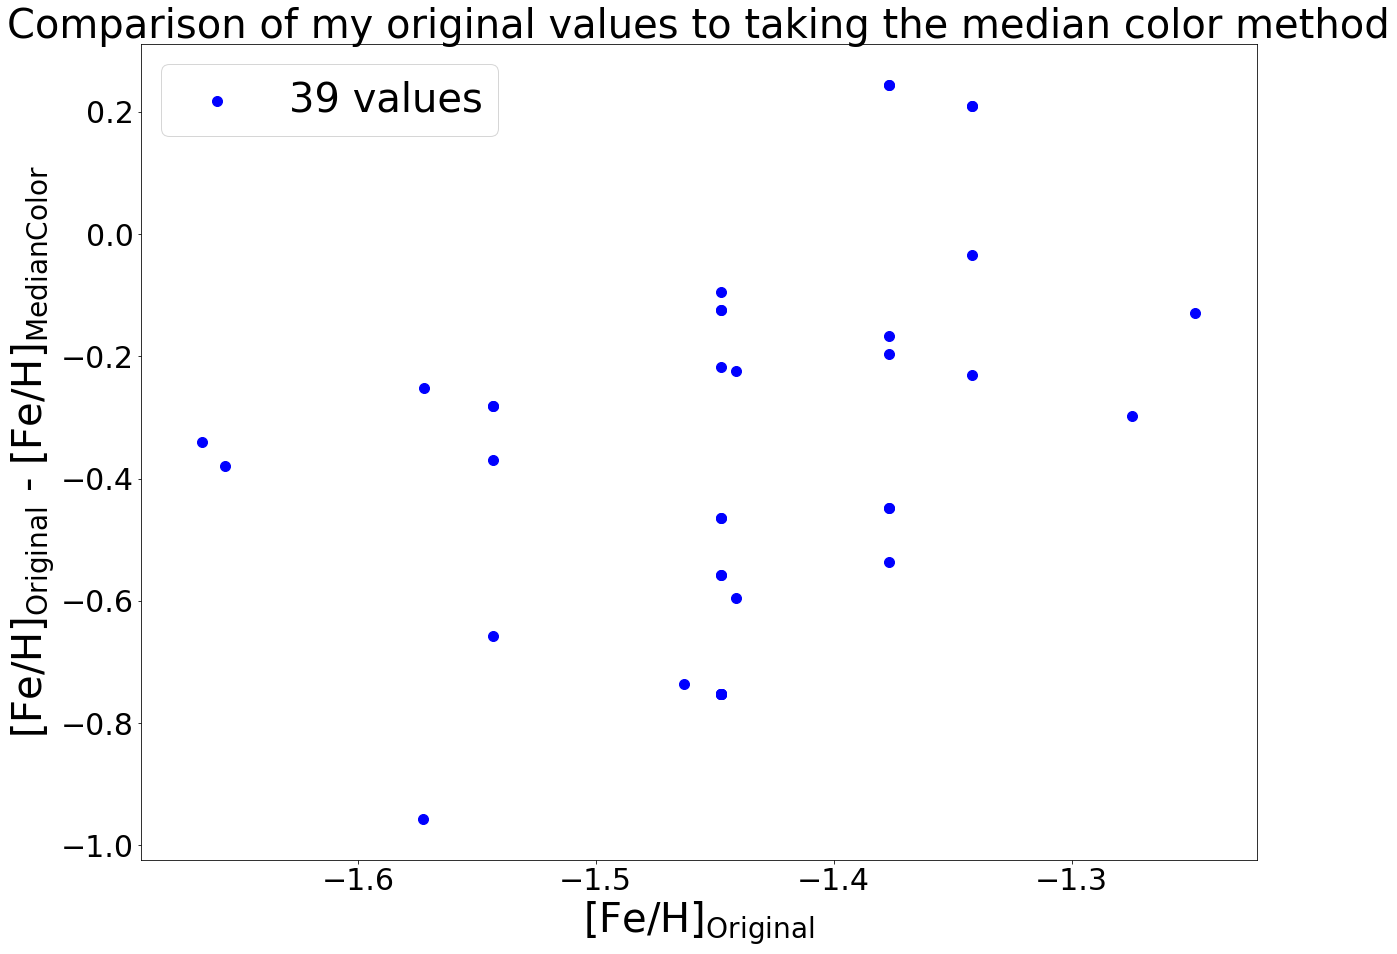

In [96]:
#x axis: [Fe/H]_spec
#y axis: delta [Fe/H]: my values - spectroscopic value: straight line
#the shape tells us about how our my method is doing
#blue = mlines.Line2D([], [], color='b', marker='o',linestyle='None',markersize=20, label='[Fe/H]$_\mathregular{Spectroscopic}$ - [Fe/H]$_\mathregular{Photometric}$')
#red = mlines.Line2D([], [], color='r', marker='None',linestyle='--',linewidth=10, label='Median')

delta = med - og

fig, ax = plt.subplots(figsize=(20,15))

ax.scatter(og,delta,c='b',s=100,label='39 values')
plt.xlabel('[Fe/H]$_\mathregular{Original}$',fontsize=40)
plt.ylabel('[Fe/H]$_\mathregular{Original}$ - [Fe/H]$_\mathregular{MedianColor}$',fontsize=40)
#plt.plot(x,y,'--',c='r',linewidth=5,label='Median')
#ax.set_xlim(-3,0)
plt.title('Comparison of my original values to taking the median color method',fontsize=40)   
ax.tick_params(axis='both', which='major', labelsize=30)
ax.legend(fontsize=40)


In [94]:
mean = np.array(metal['mean'])[~np.isnan(np.array(metal['mean']))]
og = np.array(metal['original'])[~np.isnan(np.array(metal['mean']))]

In [97]:
len(mean)

39

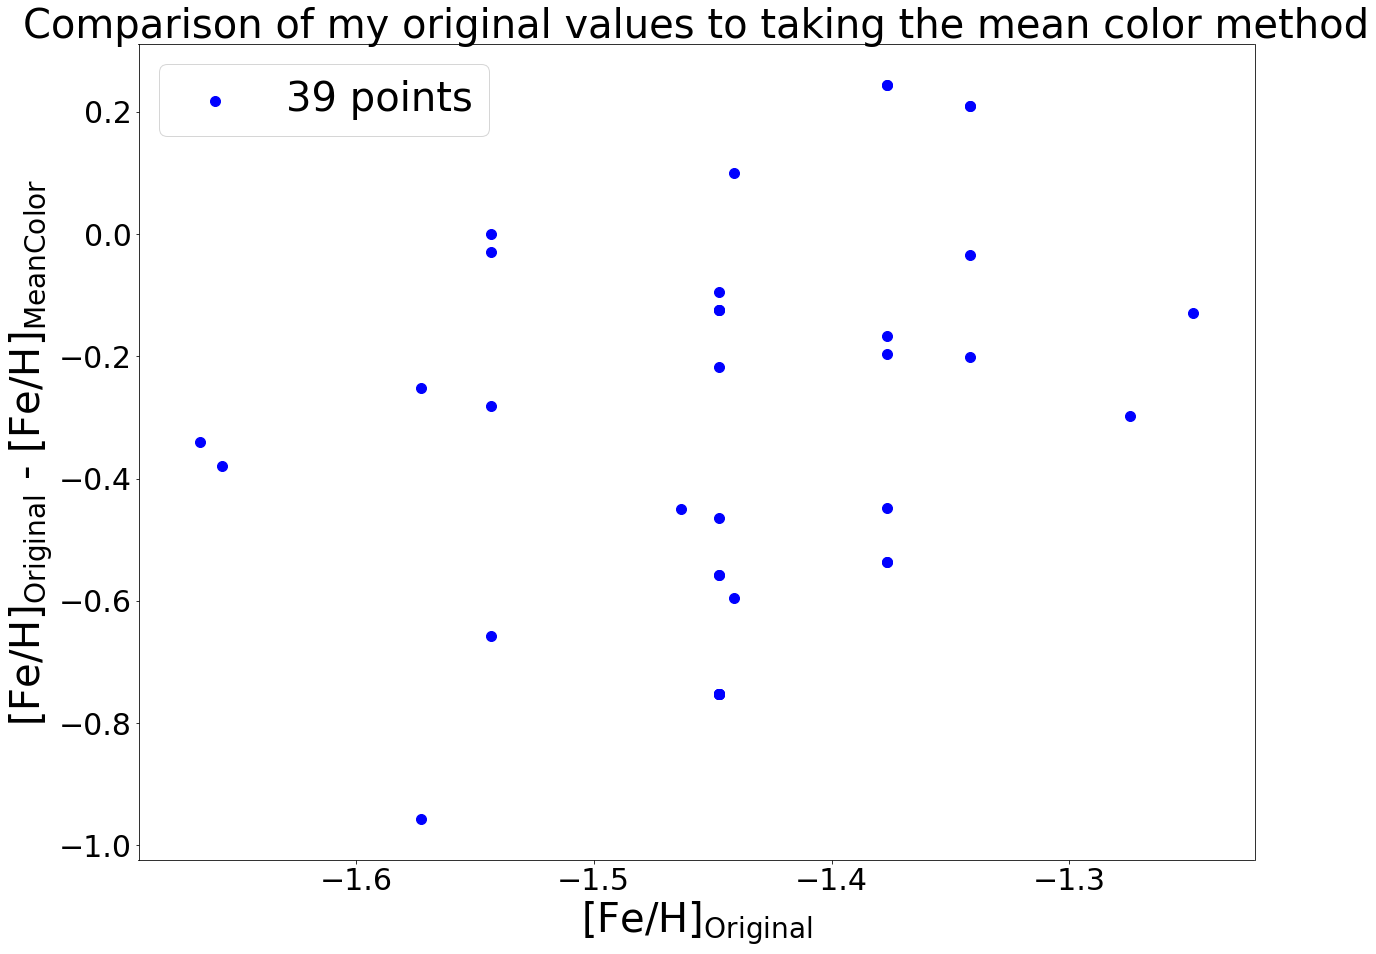

In [98]:
#x axis: [Fe/H]_spec
#y axis: delta [Fe/H]: my values - spectroscopic value: straight line
#the shape tells us about how our my method is doing
#blue = mlines.Line2D([], [], color='b', marker='o',linestyle='None',markersize=20, label='[Fe/H]$_\mathregular{Spectroscopic}$ - [Fe/H]$_\mathregular{Photometric}$')
#red = mlines.Line2D([], [], color='r', marker='None',linestyle='--',linewidth=10, label='Median')

delta = mean - og

fig, ax = plt.subplots(figsize=(20,15))

ax.scatter(og,delta,c='b',s=100,label='39 points')
plt.xlabel('[Fe/H]$_\mathregular{Original}$',fontsize=40)
plt.ylabel('[Fe/H]$_\mathregular{Original}$ - [Fe/H]$_\mathregular{MeanColor}$',fontsize=40)
#plt.plot(x,y,'--',c='r',linewidth=5,label='Median')
#ax.set_xlim(-3,0)
plt.title('Comparison of my original values to taking the mean color method',fontsize=40)   
ax.tick_params(axis='both', which='major', labelsize=30)
ax.legend(fontsize=40)
